# Activations & Gradients, BatchNorm

At initialization what we'd like is that there's 27 characters that could come next for any one training example. At initialization we have no reason to believe any character to be much more likely than others and so we'd expect that the probability distribution that comes out initially is a uniform distribution assigning about equal probability to all the 27 characters

Here's what we want the loss to be on initialisation of params:

In [13]:
import torch
-torch.tensor(1/27.0).log()

tensor(3.2958)

In our last model we get an initialisation loss of 30.049467086791992

The reason for such a high iniatial loss on our last model is that logits just take on quite extreme values. And that's what's creating the fake confidence and incorrect answers and makes the loss get very very high. So these logits should be much much closer to zero.

So initially we dont want want to keep any biases and thus initialise b2 = 0. You usually W to be small numbers instead of exactly zero. In that case our loss is close enough but has some entropy it's not exactly zero it's got some low entropy and that's used for symmetry breaking.

Secondly, tanh layer was too saturated at initialisation. What we mean by this is that most of the values in activations of the hidden layer were large in magnitude and thus took tanh value of approx 1 or -1.

Thus these points lie on the flat part of the tanh and thus the gradients vanish. So it is important to make sure that the activation values at initialisation do not completely line on the active part of tanh 

In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [15]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [16]:
len(words)

32033

In [17]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [18]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


For achieving Gaussian distributions in activations, We divide square root of fan-in (number of inputs) for weight initialization. One way to achieve this is using Kaimiing Normal in pytorch. This strategy is not actually possible for much much deeper neural Nets because when you have much deeper neural nets with lots of different types of layers it becomes really really hard to precisely set the weights and the biases in such a way that the activations are roughly uniform throughout the neural net. 

Batch Normalisation:

Standardizing hidden States so that they are unit Gaussian is a perfectly differentiable operation.

Once you have a much deeper neural net that has lots of different types of operations and there's also for example residual connections, it will become basically very very difficult to tune those scales of your weight matrices such that all the activations throughout the neural Nets are roughly gaussian and so that's going to become very quickly intractable but compared to that it's going to be much much easier to sprinkle batch normalization layers throughout the neural net.

It's customary to take these linear layer or convolutional layer and append a Batch Normalisation layer right after it. So we'd be adding these BatchNorm layers throughout the neural net and then this controls the scale of these activations throughout the neural net and it significantly stabilizes the training.

We want these to be roughly Gaussian but only at initialization but we don't want these to be to be forced to be Gaussian always. We would actually like to alow the neural nets to move this around to potentially make it more diffuse, to make it more sharp or to make some tanh neurons maybe be more trigger happy or less trigger happy. So we'd like the back propagation to tell us how that distribution should move around.

In addition to this idea of standardizing the activations at any point in the network, we have to also introduce this additional component 'the scale and shift' and so basically what we're doing is we're taking these normalized inputs and we are additionally scaling them by some gain and offsetting them by some bias to get our final output from this layer.

During optimization we'll be able to back propagate to 'bngain' and 'bnbias' and change them so the network is given the full ability to do with this whatever it wants uh internally.

In [19]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # gain/(sqrt(fan_in))
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [21]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 # hidden layer pre-activation 
    # BatchNorm layer
    #------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim = True)
    hpreact = bngain * ((hpreact - bnmeani) / (bnstdi)) + bnbias
    
    with torch.no_grad():
        # momentum = 0.001
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani 
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    #------------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 2.4409
  10000/ 200000: 1.7265
  20000/ 200000: 2.1248
  30000/ 200000: 2.2784
  40000/ 200000: 1.7993
  50000/ 200000: 2.1749
  60000/ 200000: 1.9760
  70000/ 200000: 1.7714
  80000/ 200000: 2.2191
  90000/ 200000: 2.5186
 100000/ 200000: 1.8872
 110000/ 200000: 2.0327
 120000/ 200000: 2.2863
 130000/ 200000: 2.2739
 140000/ 200000: 2.3760
 150000/ 200000: 2.1289
 160000/ 200000: 1.9701
 170000/ 200000: 2.0525
 180000/ 200000: 1.9628
 190000/ 200000: 2.2456


What's happening is you have your input and you get your "h" and then depending on the other examples this is jittering a bit and so what that does is that it's effectively padding out any one of these input examples and it's introducing a little bit of entropy and because of the padding out it's actually kind of like a form of data augmentation and that makes it harder for the neural nets to overfit to these concrete specific examples. So by introducing all this noise it actually like pads out the examples and it regularizes the neural net.

Whenever you're using batch normalization layers then if you have any weight layers before like a linear or a CONV or something like that you're better off not using bias because it's that spurious. Instead we have this Batch normalization bias and that bias is now in charge of the biasing of this distribution instead of this 'b1' that we had here originally.

If you have a very large batch size then typically what you'll see is that when you estimate the mean and the standard deviation for every single batch size if it's large enough you're going to get roughly the same result and so therefore you can use slightly higher momentum like 0.1.

If your batch size is very small momentum of 0.1 is potentially dangerous and it might make it so that the running mean and standard deviation is thrashing too much during training and it's not actually converging properly

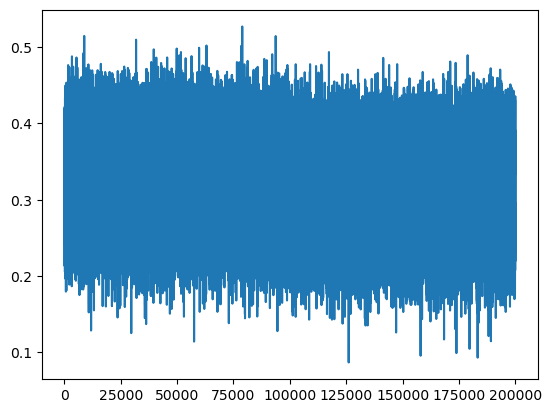

In [22]:
plt.plot(lossi)

In [23]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [24]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0530803203582764
val 2.0990729331970215


# Pytorch-ifying the code:

In [42]:

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        # .training by default is true in pytorch and nn.modules also have this attribute that training and that's
        # because many modules and batchNorm is included in that have a different behavior of whether you are 
        # training your own lot or whether you are running it in an evaluation mode and calculating your evaluation loss 
        # or using it for inference on some test examples
        self.training = True 
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True)   # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalise to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var =  (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out        
        
    def parameters(self):
        return [self.gamma, self.beta]
        
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    #layers[-1].weight *= 0.1 --> without batchnorm as outpul layer
    layers[-1].gamma *= 0.1 # as last layer is batchNorm
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear): 
            layer.weight *= 5/3 # gain required to fight the squashing of distributions by tanh activation
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True

47551


Why do we use an activation like tanh at all?

Basically the tanh non linearities allow us to turn this linear sandwich from just a linear function into a neural network that can, in principle, approximate any arbitrary function.

In [38]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad 
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i>=1000:
        break # AFTER_DEBUG: would take out obviously to run full optimisation 

      0/ 200000: 3.2699


layer 2 (      Tanh): mean +0.00, std 0.62, saturated: 3.38%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.78%
layer 8 (      Tanh): mean +0.01, std 0.64, saturated: 2.75%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.06%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

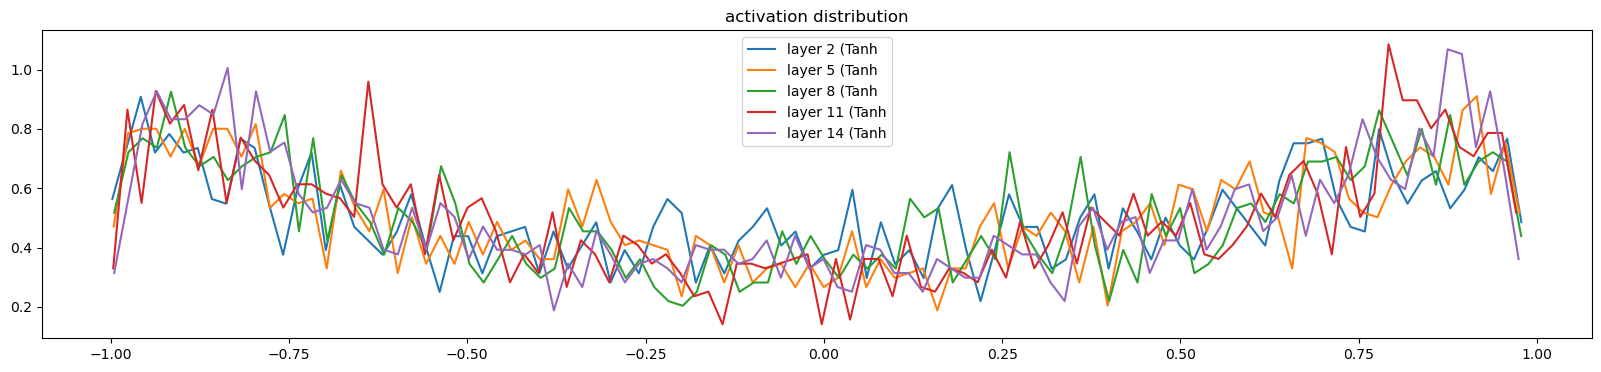

In [39]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

weight   (27, 10) | mean +0.000000 | std 5.842188e-03 | grad:data ratio 5.662953e-03
weight  (30, 100) | mean -0.000120 | std 5.567129e-03 | grad:data ratio 1.804800e-02
weight (100, 100) | mean -0.000058 | std 4.801459e-03 | grad:data ratio 2.853427e-02
weight (100, 100) | mean +0.000029 | std 4.473506e-03 | grad:data ratio 2.669961e-02
weight (100, 100) | mean +0.000002 | std 4.418779e-03 | grad:data ratio 2.634950e-02
weight (100, 100) | mean -0.000018 | std 4.272965e-03 | grad:data ratio 2.532006e-02
weight  (100, 27) | mean +0.000076 | std 8.604733e-03 | grad:data ratio 5.158221e-02


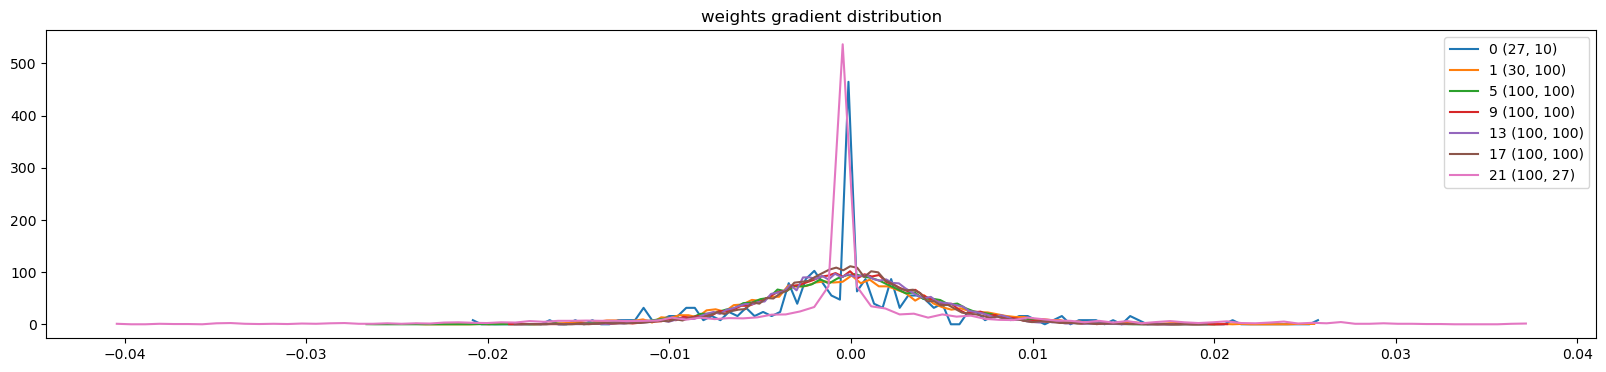

In [40]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

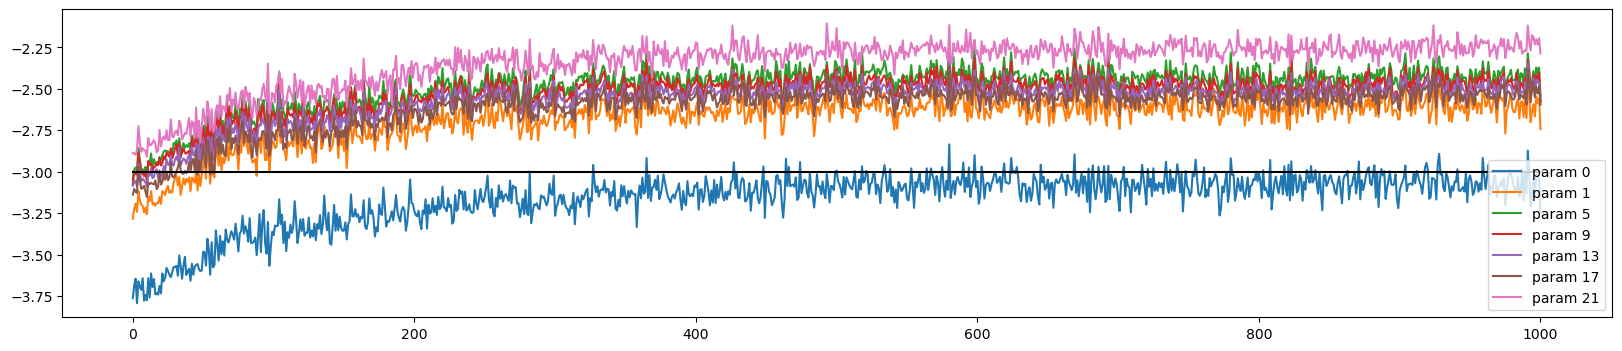

In [41]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
